In [18]:
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import pickle
import json
from tqdm import tqdm

import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,BertTokenizer

In [2]:
class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """

    def __init__(self, refs, annotations, split="train"):
        """
        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": clip.tokenize(elem["sentences"][0]["raw"]),
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]
    """
    def __init__(self, refs, annotations, tokenizer, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": tokenizer(
                                    elem["sentences"][0]["raw"], padding = "max_length", truncation=True, max_length=70,
                                    return_attention_mask = False
                                ),
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [4]:
def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    #pad_width = padded_width - original_width
    #pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = [] #tensors of images
    captions = []
    for sample in batch:
        #print(sample)
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
        #print(sample['caption'][0]['input_ids'])
        caption = sample['caption']['input_ids']
        captions.append(caption)
        #images.append(sample["file_name"])

    images = torch.stack(images, dim=0)
    captions = torch.tensor(captions)
    
    return images, data, captions

def collate_fn2(batch):
    images, caption_tokens = zip(*batch)
    #print(images)
    # Process images
    transform = transforms.Compose([
        transforms.Pad(0, fill=0),  # Replace padding_value with your desired padding
        transforms.Resize((224, 224)),  # ResNet-50 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensors = torch.stack([transform(img) for img in images])

    # Tokenize the captions using the CLIP tokenizer
    caption_lengths = [len(tokens) for tokens in caption_tokens]
    #max_caption_length = max(caption_lengths)
    captions = [item[1] for item in batch]
    #added_caption_tokens = [tokens + [0] * (max_caption_length - len(tokens)) for tokens in caption_tokens]
    caption_tensors = torch.tensor(captions)

    return {'images': image_tensors, 'captions': caption_tensors, 'caption_lengths': caption_lengths}

transform = transforms.Compose([
    transforms.Pad(0, fill=0),  # Replace padding_value with your desired padding
    transforms.Resize((224, 224)),  # ResNet-50 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Text Encoder

In [5]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = True

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

{'file_name': './refcocog/images/COCO_train2014_000000245806.jpg', 'caption': {'input_ids': [101, 1996, 2158, 8434, 1996, 28470, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'ann_id': 513409, 'bbox': [139.82, 89.37, 223.42, 498.74]}


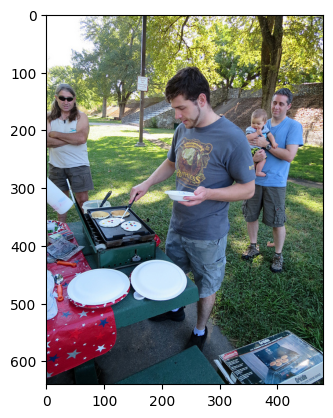

In [6]:
#tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = RefCOCOg(refs, annotations, tokenizer, split="train")
plt.imshow(Image.open(dataset_train[7341]["file_name"]))
print(dataset_train[7341])
dataloader_train = DataLoader(dataset_train, batch_size=1, collate_fn=collate_fn)


In [7]:
dataset_test = RefCOCOg(refs, annotations, tokenizer, split="test")
dataloader_test = DataLoader(dataset_test, batch_size=1, collate_fn=collate_fn)



# Image Encoder

In [8]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)   
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [9]:
from transformers import AutoImageProcessor, ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [10]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(self):
        super().__init__()
        self.model = model
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.model(x)

# Projection Layer

In [11]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        #print(self.projection.dtype)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# clip

In [26]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
        image_embedding=1000, #resnet50 output
        text_embedding=70, # dimension searched heuristically
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, img, text):
        # Getting Image and Text Features
        #print("madonna buhaiola")
        image_features = self.image_encoder(img)
        text_features = text
        #print("init done")
        #print(image_features)
        #print(len(image_features['logits']))
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features['logits'])
        #print("image embedding done")
        #print(text_features)
        #print(len(text_features[0]))
        text_embeddings = self.text_projection(text_features)
        #print("embeddings done")

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        print('The value of logits is {} image sim is {} text sim is {}'.format(logits,images_similarity,texts_similarity))

        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        print(targets)
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')

        print("Loss testo:{}, Loss immagine {}".format(texts_loss, images_loss) )
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [13]:
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [15]:
#main()

In [27]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    with tqdm(dataloader_test, unit="batch") as tepoch:
        for data,_, caption in tepoch:
            data = data.to(device)
            #print(dic['caption'][0])
            caption = caption.type('torch.FloatTensor')
            caption = caption.to(device)
            loss = model(data,caption)
            print(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step == "batch":
                lr_scheduler.step()
            count = data.size(0)
            print(count)
            loss_meter.update(loss.item(), count)
            tepoch.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    with tqdm(dataloader_test, unit="batch") as tepoch:
        for data,_, caption in tepoch:
            data = data.to(device)
            #print(dic['caption'][0])
            caption = caption.type('torch.FloatTensor')
            caption = caption.to(device)
            loss = model(data,caption)
           
            count = data.size(0)
            loss_meter.update(loss.item(), count)
            tepoch.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    model = CLIPModel().to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": 1e-4},
        {"params": model.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": 1e-3, "weight_decay": 1e-3}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.8
    )
    step = "epoch"

    best_loss = float('inf')
    eval_loss = 0
    loss_meter = AvgMeter()

    for epoch in range(0,2):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, dataloader_train, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, dataloader_test)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [28]:
main()

Epoch: 1


  0%|          | 3/5023 [00:00<02:56, 28.37batch/s, lr=0.0001, train_loss=0]

The value of logits is tensor([[-11.2363]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9999]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[256.]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[1.8597]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9994]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9995]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[0.3020]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9988]], device='cuda:0', grad_fn=

  0%|          | 10/5023 [00:00<02:49, 29.53batch/s, lr=0.0001, train_loss=0]

The value of logits is tensor([[-2.0943]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9967]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9969]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[8.1309]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9963]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9964]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[-3.6463]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9957]], device='cuda:0', grad

  0%|          | 16/5023 [00:00<02:56, 28.38batch/s, lr=0.0001, train_loss=0]

The value of logits is tensor([[-3.5200]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9937]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9937]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[-7.9010]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9931]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9933]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[-16.0558]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9927]], device='cuda:0', gr

  0%|          | 24/5023 [00:00<02:47, 29.93batch/s, lr=0.0001, train_loss=0]

The value of logits is tensor([[-10.8508]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9906]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9907]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[0.6007]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9900]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9902]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0
1
The value of logits is tensor([[-2.2862]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9895]], device='cuda:0', gra

  0%|          | 25/5023 [00:00<02:54, 28.61batch/s, lr=0.0001, train_loss=0]


1
The value of logits is tensor([[-5.0576]], device='cuda:0', grad_fn=<DivBackward0>) image sim is tensor([[255.9869]], device='cuda:0', grad_fn=<MmBackward0>) text sim is tensor([[255.9870]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Loss testo:tensor([0.], device='cuda:0', grad_fn=<SumBackward1>), Loss immagine tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
0.0


KeyboardInterrupt: 

In [14]:

import itertools


def main():
    #tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = CLIPModel().to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": 1e-4},
        {"params": model.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": 1e-3, "weight_decay": 1e-3}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.8
    )
    step = "epoch"

    best_loss = float('inf')
    eval_loss = 0

    loss_meter = AvgMeter()
    for epoch in range(1, 5):
        loss_meter = AvgMeter()
        with tqdm(dataloader_test, unit="batch") as tepoch:
            print("INIT STEP 0")
            print(tepoch)
            print("LOL")
            for data,_, caption in tepoch:
                model.train()
                data = data.to(device)
                #print(dic['caption'][0])
                caption = caption.type('torch.FloatTensor')
                caption = caption.to(device)
                tepoch.set_description(f"Epoch {epoch}")
                loss = model(data,caption)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if step == "batch":
                    lr_scheduler.step()
                count = len(data)
                loss_meter.update(loss.item(), count)

                tepoch.set_postfix(loss=loss_meter.avg, lr=get_lr(optimizer))

                model.eval()
                with torch.no_grad():
                    loss_meter = AvgMeter()
                    loss = model(data,caption)
                    count = len(data)
                    loss_meter.update(loss.item(), count)
                    eval_loss = loss_meter
                    tepoch.set_postfix(valid_loss=loss_meter.avg)
                
                if eval_loss.avg < best_loss:
                    best_loss = eval_loss.avg
                    torch.save(model.state_dict(), "best.pt")
                    print("Saved Best Model!")
        print("epoch finished")

In [24]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased')

    model = CLIPModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for data,_, caption in tqdm(dataloader_train):
            image_features = model.image_encoder(data.to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [25]:
model, image_embeddings = get_image_embeddings(dataloader_test, "best.pt")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
  0%|          | 0/42226 [00:00<?, ?it/s]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not ImageClassifierOutputWithNoAttention